CT Training and Reconstruction with ODP
=======================================

This example demonstrates the training of the unrolled optimization with
deep priors (ODP) gradient descent architecture described in
<cite data-cite="diamond-2018-odp"/> applied to a CT reconstruction problem.

The source images are foam phantoms generated with xdesign.

A class
[scico.flax.ODPNet](../_autosummary/scico.flax.rst#scico.flax.ODPNet)
implements the ODP architecture, which solves the optimization problem

$$\mathrm{argmin}_{\mathbf{x}} \; \| A \mathbf{x} - \mathbf{y} \|_2^2
+ r(\mathbf{x}) \;,$$

where $A$ is a tomographic projector, $\mathbf{y}$ is a set of sinograms,
$r$ is a regularizer and $\mathbf{x}$ is the set of reconstructed images.
The ODP, gradient descent architecture, abstracts the iterative solution
by an unrolled network where each iteration corresponds to a different
stage in the ODP network and updates the prediction by solving

$$\mathbf{x}^{k+1} = \mathrm{argmin}_{\mathbf{x}} \; \alpha_k \| A
\mathbf{x} - \mathbf{y} \|_2^2 + \frac{1}{2} \| \mathbf{x} -
\mathbf{x}^k - \mathbf{x}^{k+1/2} \|_2^2 \;,$$

which for the CT problem, using gradient descent, corresponds to

$$\mathbf{x}^{k+1} = \mathbf{x}^k + \mathbf{x}^{k+1/2} - \alpha_k \,
A^T \, (A \mathbf{x}^k - \mathbf{y}) \;,$$

where $k$ is the index of the stage (iteration), $\mathbf{x}^k +
\mathbf{x}^{k+1/2} = \mathrm{ResNet}(\mathbf{x}^{k})$ is the
regularization (implemented as a residual convolutional neural network),
$\mathbf{x}^k$ is the output of the previous stage and $\alpha_k > 0$ is
a learned stage-wise parameter weighting the contribution of the fidelity
term. The output of the final stage is the set of reconstructed images.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico
!pip install ray

# isort: off
import os
from functools import partial
from time import time

import numpy as np

import logging
import ray

ray.init(logging_level=logging.ERROR)  # need to call init before jax import: ray-project/ray#44087

# Set an arbitrary processor count (only applies if GPU is not available).
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import jax

try:
    from jax.extend.backend import get_backend  # introduced in jax 0.4.33
except ImportError:
    from jax.lib.xla_bridge import get_backend

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scico import flax as sflax
from scico import metric, plot
from scico.flax.examples import load_ct_data
from scico.flax.train.traversals import clip_positive, construct_traversal
from scico.linop.xray import XRayTransform2D
plot.config_notebook_plotting()


platform = get_backend().platform
print("Platform: ", platform)

Platform:  gpu


Read data from cache or generate if not available.

In [2]:
N = 256  # phantom size
train_nimg = 536  # number of training images
test_nimg = 64  # number of testing images
nimg = train_nimg + test_nimg
n_projection = 45  # CT views

trdt, ttdt = load_ct_data(train_nimg, test_nimg, N, n_projection, verbose=True)

Data read from path: ~/.cache/scico/examples/data
Set --training-- size: 536
Set --testing -- size: 64
Data range --images  --  Min:  0.00  Max:  1.00
Data range --sinogram--  Min:  0.00  Max:  0.95
Data range --FBP     --  Min:  0.00  Max:  1.00


Build CT projection operator. Parameters are chosen so that the operator
is equivalent to the one used to generate the training data.

In [3]:
angles = np.linspace(0, np.pi, n_projection, endpoint=False)  # evenly spaced projection angles
A = XRayTransform2D(
    input_shape=(N, N),
    angles=angles,
    det_count=int(N * 1.05 / np.sqrt(2.0)),
    dx=1.0 / np.sqrt(2),
)
A = (1.0 / N) * A  # normalize projection operator

Build training and testing structures. Inputs are the sinograms and
outputs are the original generated foams. Keep training and testing
partitions.

In [4]:
numtr = 320
numtt = 32
train_ds = {"image": trdt["sino"][:numtr], "label": trdt["img"][:numtr]}
test_ds = {"image": ttdt["sino"][:numtt], "label": ttdt["img"][:numtt]}

Define configuration dictionary for model and training loop.

Parameters have been selected for demonstration purposes and relatively
short training. The model depth is akin to the number of unrolled
iterations in the MoDL model. The block depth controls the number of
layers at each unrolled iteration. The number of filters is uniform
throughout the iterations. The iterations used for the conjugate gradient
(CG) solver can also be specified. Better performance may be obtained by
increasing depth, block depth, number of filters, CG iterations, or
training epochs, but may require longer training times.

In [5]:
# model configuration
model_conf = {
    "depth": 8,
    "num_filters": 64,
    "block_depth": 6,
}
# training configuration
train_conf: sflax.ConfigDict = {
    "seed": 1234,
    "opt_type": "ADAM",
    "batch_size": 16,
    "num_epochs": 200,
    "base_learning_rate": 1e-3,
    "warmup_epochs": 0,
    "log_every_steps": 160,
    "log": True,
    "checkpointing": True,
}

Construct functionality for ensuring that the learned fidelity weight
parameter is always positive.

In [6]:
alphatrav = construct_traversal("alpha")  # select alpha parameters in model
alphapost = partial(
    clip_positive,  # apply this function
    traversal=alphatrav,  # to alpha parameters in model
    minval=1e-3,
)

Print configuration of distributed run.

In [7]:
print(f"\nJAX process: {jax.process_index()}{' / '}{jax.process_count()}")
print(f"JAX local devices: {jax.local_devices()}\n")


JAX process: 0 / 1
JAX local devices: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3), CudaDevice(id=4), CudaDevice(id=5), CudaDevice(id=6), CudaDevice(id=7)]



Construct ODPNet model.

In [8]:
channels = train_ds["image"].shape[-1]
model = sflax.ODPNet(
    operator=A,
    depth=model_conf["depth"],
    channels=channels,
    num_filters=model_conf["num_filters"],
    block_depth=model_conf["block_depth"],
    odp_block=sflax.inverse.ODPGrDescBlock,
    alpha_ini=1e-2,
)

Run training loop.

In [9]:
workdir = os.path.join(os.path.expanduser("~"), ".cache", "scico", "examples", "odp_ct_out")

train_conf["workdir"] = workdir
train_conf["post_lst"] = [alphapost]
# Construct training object
trainer = sflax.BasicFlaxTrainer(
    train_conf,
    model,
    train_ds,
    test_ds,
)
modvar, stats_object = trainer.train()

channels: 1   training signals: 320   testing signals: 32   signal size: 256



Network Structure:
+---------------------------------------------------------+----------------+--------+-----------+--------+
| Name                                                    | Shape          | Size   | Mean      | Std    |
+---------------------------------------------------------+----------------+--------+-----------+--------+
| ODPGrDescBlock_0/alpha                                  | (1,)           | 1      | 0.01      | 0.0    |
| ODPGrDescBlock_0/resnet/BatchNorm_0/bias                | (1,)           | 1      | 0.0       | 0.0    |
| ODPGrDescBlock_0/resnet/BatchNorm_0/scale               | (1,)           | 1      | 1.0       | 0.0    |
| ODPGrDescBlock_0/resnet/ConvBNBlock_0/BatchNorm_0/bias  | (64,)          | 64     | 0.0       | 0.0    |
| ODPGrDescBlock_0/resnet/ConvBNBlock_0/BatchNorm_0/scale | (64,)          | 64     | 1.0       | 0.0    |
| ODPGrDescBlock_0/resnet/ConvBNBlock_0/Conv_0/kernel     | (3, 3, 1, 64)  | 576    | -0.000308 | 0.0568 |
| ODPGrDescBlock_0

Initial compilation, which might take some time ...


Initial compilation completed.



Epoch  Time      Train_LR  Train_Loss  Train_SNR  Eval_Loss  Eval_SNR
---------------------------------------------------------------------
    7  4.32e+01  0.001000    0.060359       2.39   0.066654     -1.62


   15  7.39e+01  0.001000    0.013261       5.47   0.105078     -3.60


   23  1.02e+02  0.001000    0.015398       5.21   0.050193     -0.39


   31  1.31e+02  0.001000    0.009952       6.79   0.114669     -3.98


   39  1.58e+02  0.001000    0.005990       8.84   0.087814     -2.82


   47  1.87e+02  0.001000    0.005258       9.41   0.021021      3.39


   55  2.16e+02  0.001000    0.004950       9.67   0.007498      7.87


   63  2.45e+02  0.001000    0.004715       9.88   0.005119      9.53


   71  2.74e+02  0.001000    0.004438      10.14   0.004863      9.75


   79  3.02e+02  0.001000    0.004329      10.25   0.004909      9.71


   87  3.31e+02  0.001000    0.004173      10.41   0.005542      9.18


   95  3.59e+02  0.001000    0.004058      10.53   0.004768      9.84


  103  3.89e+02  0.001000    0.004002      10.59   0.004059     10.53


  111  4.18e+02  0.001000    0.003896      10.71   0.004134     10.45


  119  4.46e+02  0.001000    0.003892      10.71   0.005176      9.48


  127  4.75e+02  0.001000    0.003798      10.82   0.004062     10.53


  135  5.04e+02  0.001000    0.003742      10.88   0.004029     10.57


  143  5.33e+02  0.001000    0.003677      10.96   0.004096     10.50


  151  5.62e+02  0.001000    0.003630      11.01   0.004611      9.98


  159  5.90e+02  0.001000    0.003580      11.08   0.004156     10.43


  167  6.19e+02  0.001000    0.003566      11.09   0.003676     10.97


  175  6.48e+02  0.001000    0.003497      11.18   0.004275     10.31


  183  6.77e+02  0.001000    0.003487      11.19   0.003615     11.04


  191  7.07e+02  0.001000    0.003418      11.28   0.003709     10.93


  199  7.35e+02  0.001000    0.003399      11.30   0.004099     10.49


Evaluate on testing data.

In [10]:
del train_ds["image"]
del train_ds["label"]

fmap = sflax.FlaxMap(model, modvar)
del model, modvar

maxn = numtt
start_time = time()
output = fmap(test_ds["image"][:maxn])
time_eval = time() - start_time
output = np.clip(output, a_min=0, a_max=1.0)
epochs = train_conf["num_epochs"]

Evaluate trained model in terms of reconstruction time and data fidelity.

In [11]:
snr_eval = metric.snr(test_ds["label"][:maxn], output)
psnr_eval = metric.psnr(test_ds["label"][:maxn], output)
print(
    f"{'ODPNet training':18s}{'epochs:':2s}{epochs:>5d}{'':21s}"
    f"{'time[s]:':10s}{trainer.train_time:>7.2f}"
)
print(
    f"{'ODPNet testing':18s}{'SNR:':5s}{snr_eval:>5.2f}{' dB'}{'':3s}"
    f"{'PSNR:':6s}{psnr_eval:>5.2f}{' dB'}{'':3s}{'time[s]:':10s}{time_eval:>7.2f}"
)

ODPNet training   epochs:  200                     time[s]:   736.83
ODPNet testing    SNR: 10.65 dB   PSNR: 21.03 dB   time[s]:     8.05


Plot comparison.

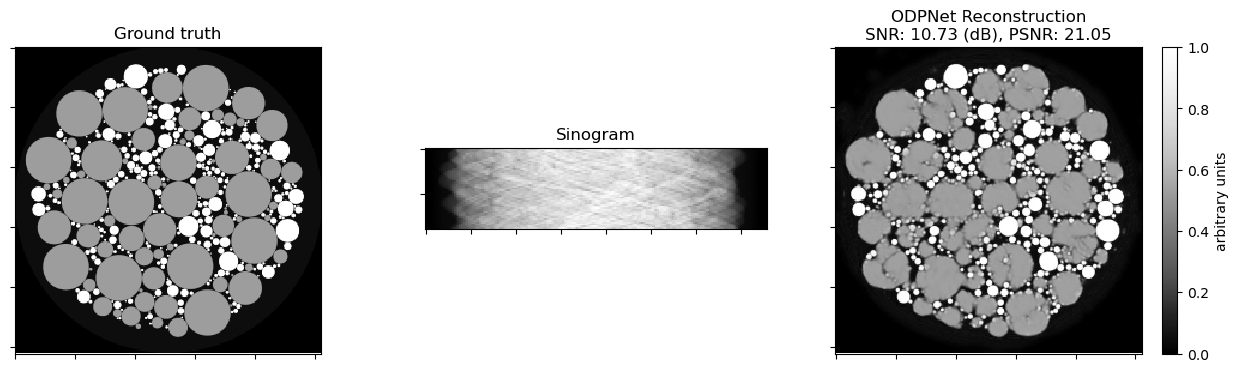

In [12]:
np.random.seed(123)
indx = np.random.randint(0, high=maxn)

fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(test_ds["label"][indx, ..., 0], title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    test_ds["image"][indx, ..., 0],
    title="Sinogram",
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    output[indx, ..., 0],
    title="ODPNet Reconstruction\nSNR: %.2f (dB), PSNR: %.2f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
        metric.psnr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
    ),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics. Statistics are generated only if a training
cycle was done (i.e. if not reading final epoch results from checkpoint).

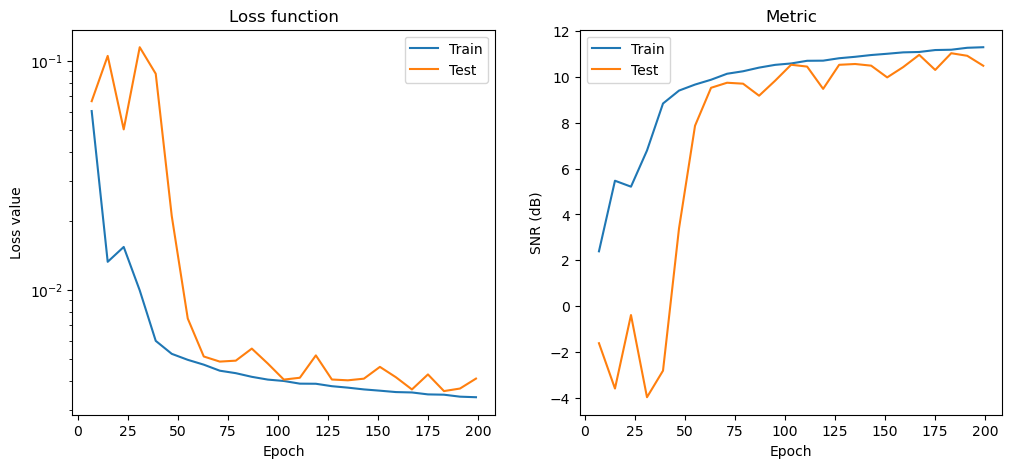

In [13]:
if stats_object is not None and len(stats_object.iterations) > 0:
    hist = stats_object.history(transpose=True)
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot.plot(
        np.vstack((hist.Train_Loss, hist.Eval_Loss)).T,
        x=hist.Epoch,
        ptyp="semilogy",
        title="Loss function",
        xlbl="Epoch",
        ylbl="Loss value",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[0],
    )
    plot.plot(
        np.vstack((hist.Train_SNR, hist.Eval_SNR)).T,
        x=hist.Epoch,
        title="Metric",
        xlbl="Epoch",
        ylbl="SNR (dB)",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[1],
    )
    fig.show()